#  Supervised Learning Assignment

####  S. Parker 2016

This notebook will examine the phishing dataset with decision trees.  It will look at the effectiveness of the decision trees relative to:

*  Levels in the decision tree
*  Number of training samples
*  Bias vs variance calculations
*  Performance metrics (memory used, time to fit, time to predict)

Also explored will be the effect of pre-pruning the data set and how this affects performance.

In [1]:
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn.externals.six import StringIO  
import pandas as pd
import pydotplus
import numpy as np
import os, sys
import timeit
from IPython.display import display, HTML
from IPython.display import Image 
import matplotlib.pyplot as plt
%matplotlib inline
import arff

from supervised_learning import *

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

####  Control variables for simulation

In [2]:
training_test_split = .65

####  Helper function to allow us to get the size of the learning model

In [3]:
import sys
from numbers import Number
from collections import Set, Mapping, deque

try: # Python 2
    zero_depth_bases = (basestring, Number, xrange, bytearray)
    iteritems = 'iteritems'
except NameError: # Python 3
    zero_depth_bases = (str, bytes, Number, range, bytearray)
    iteritems = 'items'

def getsize(obj_0):
    """Recursively iterate to sum size of object & members."""
    def inner(obj, _seen_ids = set()):
        obj_id = id(obj)
        if obj_id in _seen_ids:
            return 0
        _seen_ids.add(obj_id)
        size = sys.getsizeof(obj)
        if isinstance(obj, zero_depth_bases):
            pass # bypass remaining control flow and return
        elif isinstance(obj, (tuple, list, Set, deque)):
            size += sum(inner(i) for i in obj)
        elif isinstance(obj, Mapping) or hasattr(obj, iteritems):
            size += sum(inner(k) + inner(v) for k, v in getattr(obj, iteritems)())
        # Check for custom object instances - may subclass above too
        if hasattr(obj, '__dict__'):
            size += inner(vars(obj))
        if hasattr(obj, '__slots__'): # can have __slots__ with __dict__
            size += sum(inner(getattr(obj, s)) for s in obj.__slots__ if hasattr(obj, s))
        return size
    return inner(obj_0)

##  Load and prepare training set #1

For this assignment I choose the following two data sets:
    
*  Phishing data set - looks at various attributes of a website address and compute whether the site if a phishing site or not

In [21]:
df_training, df_testing = loadSpamDataSet()
#df_training, df_testing = loadPhishingDataSet()

dataset = "Spam"

In [5]:
df_training.head()

,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,...,0.40,0.41,0.42,0.778,0.43,0.44,3.756,61,278,1
0,0.21,0.28,0.50,0.0,0.0,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,0.0,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.0,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.0,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.0,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


##  Vary Decision Tree Depth to see effect on training and testing sets

In [6]:
clf = tree.DecisionTreeClassifier()

In [7]:
df_training.columns.values

array(['0', '0.64', '0.64.1', '0.1', '0.32', '0.2', '0.3', '0.4', '0.5',
       '0.6', '0.7', '0.64.2', '0.8', '0.9', '0.10', '0.32.1', '0.11',
       '1.29', '1.93', '0.12', '0.96', '0.13', '0.14', '0.15', '0.16',
       '0.17', '0.18', '0.19', '0.20', '0.21', '0.22', '0.23', '0.24',
       '0.25', '0.26', '0.27', '0.28', '0.29', '0.30', '0.31', '0.32',
       '0.33', '0.34', '0.35', '0.36', '0.37', '0.38', '0.39', '0.40',
       '0.41', '0.42', '0.778', '0.43', '0.44', '3.756', '61', '278', '1'], dtype=object)

In [8]:
clf.fit(df_training.values[:,0:-1], df_training.values[:,-1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

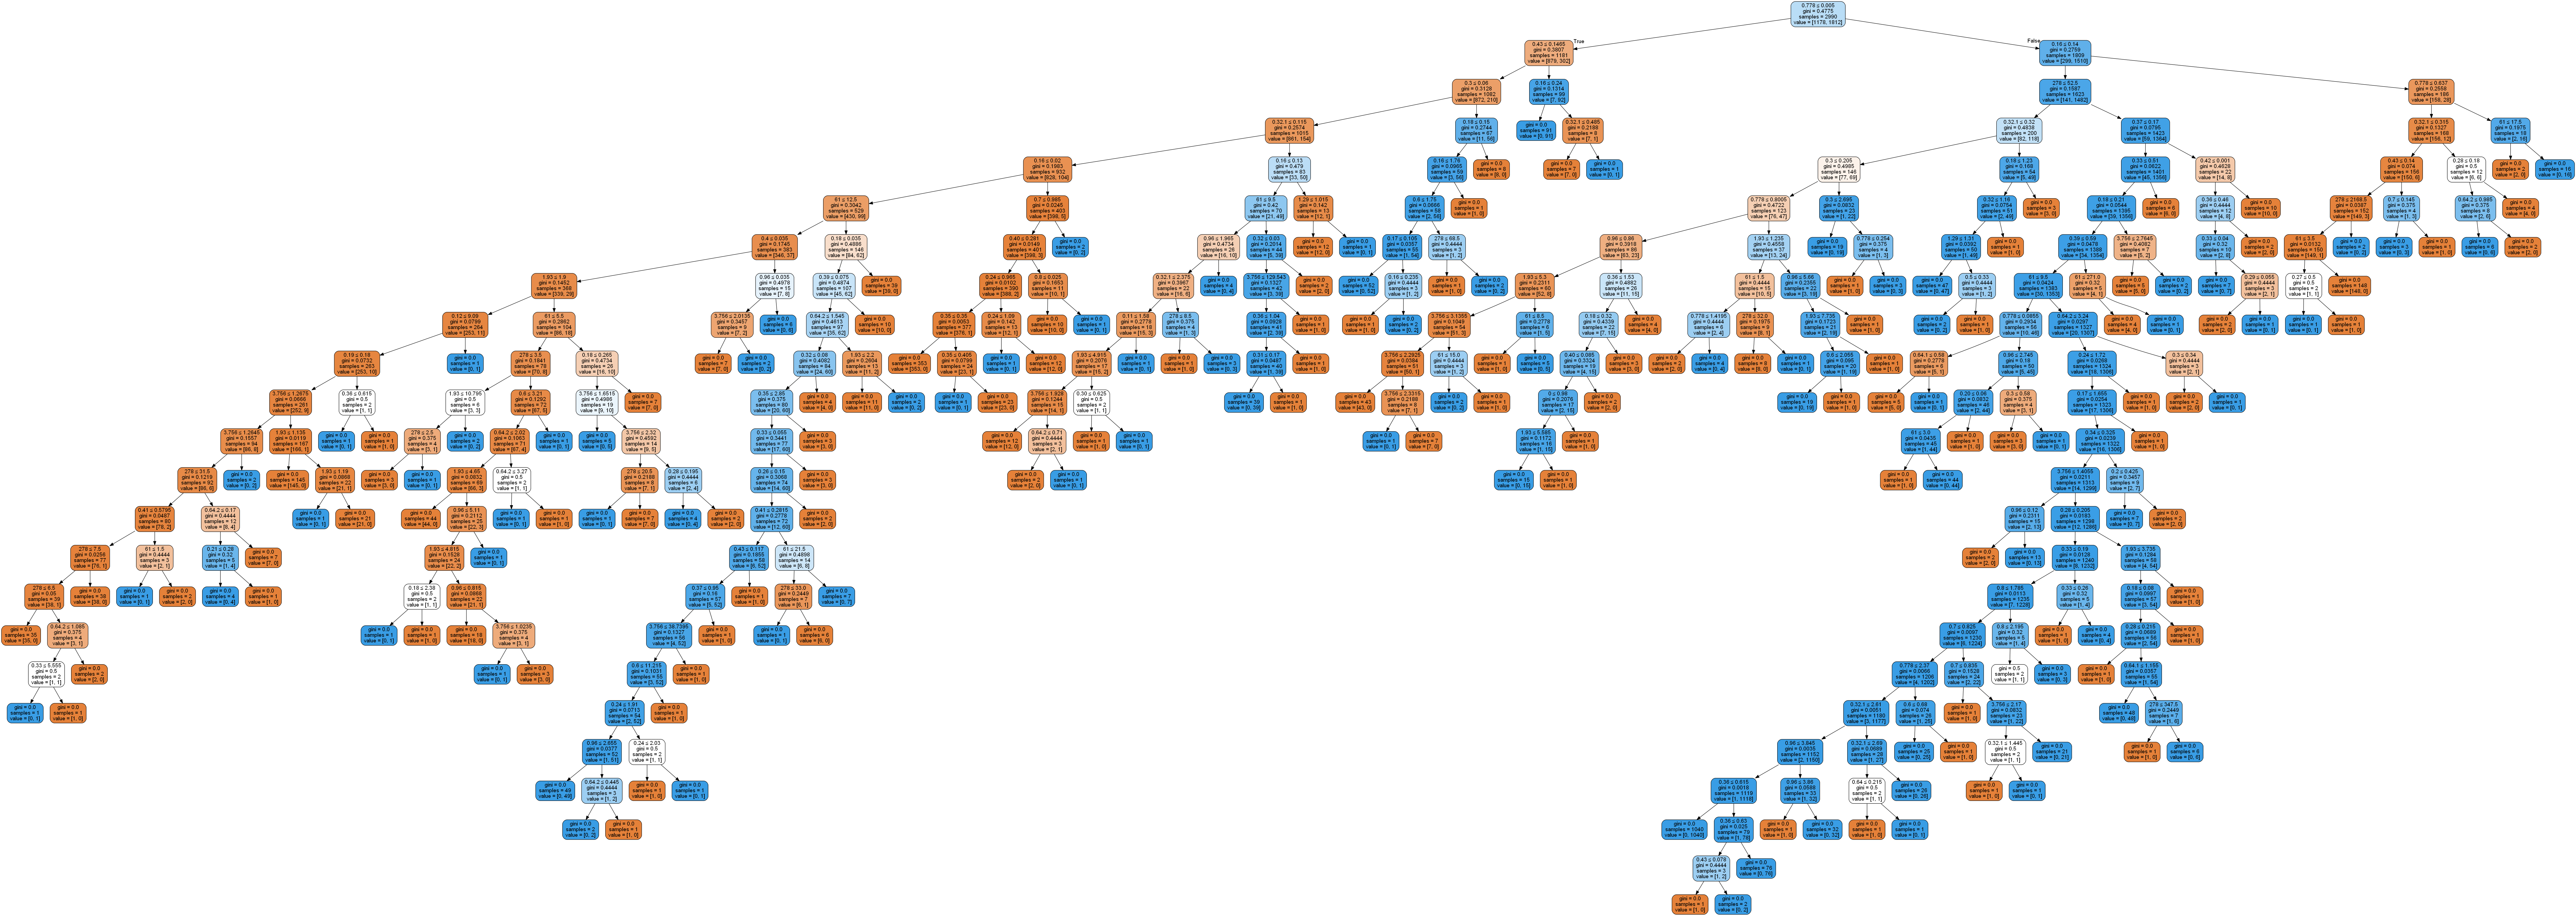

In [9]:
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                     feature_names=df_training.columns.values[0:-1],  
                     #class_names=["False", "True"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

####  Feature Importance.  For this part of the study, we will look at different features at look at their importance relative to the overall decision tree.

In [10]:
len(clf.feature_importances_)

57

In [11]:
df_importance = pd.DataFrame()
df_importance["attribute"] = list(df_training.columns.values)[0:-1]
df_importance["importance"] = clf.feature_importances_
display(HTML(df_importance.sort_values(by="importance", ascending=0).to_html(index=False)))

attribute,importance
0.778,0.363277
0.16,0.161900
0.43,0.073718
0.3,0.052468
278,0.047190
0.32.1,0.043694
61,0.039776
0.18,0.036891
0.96,0.019921
1.93,0.019790


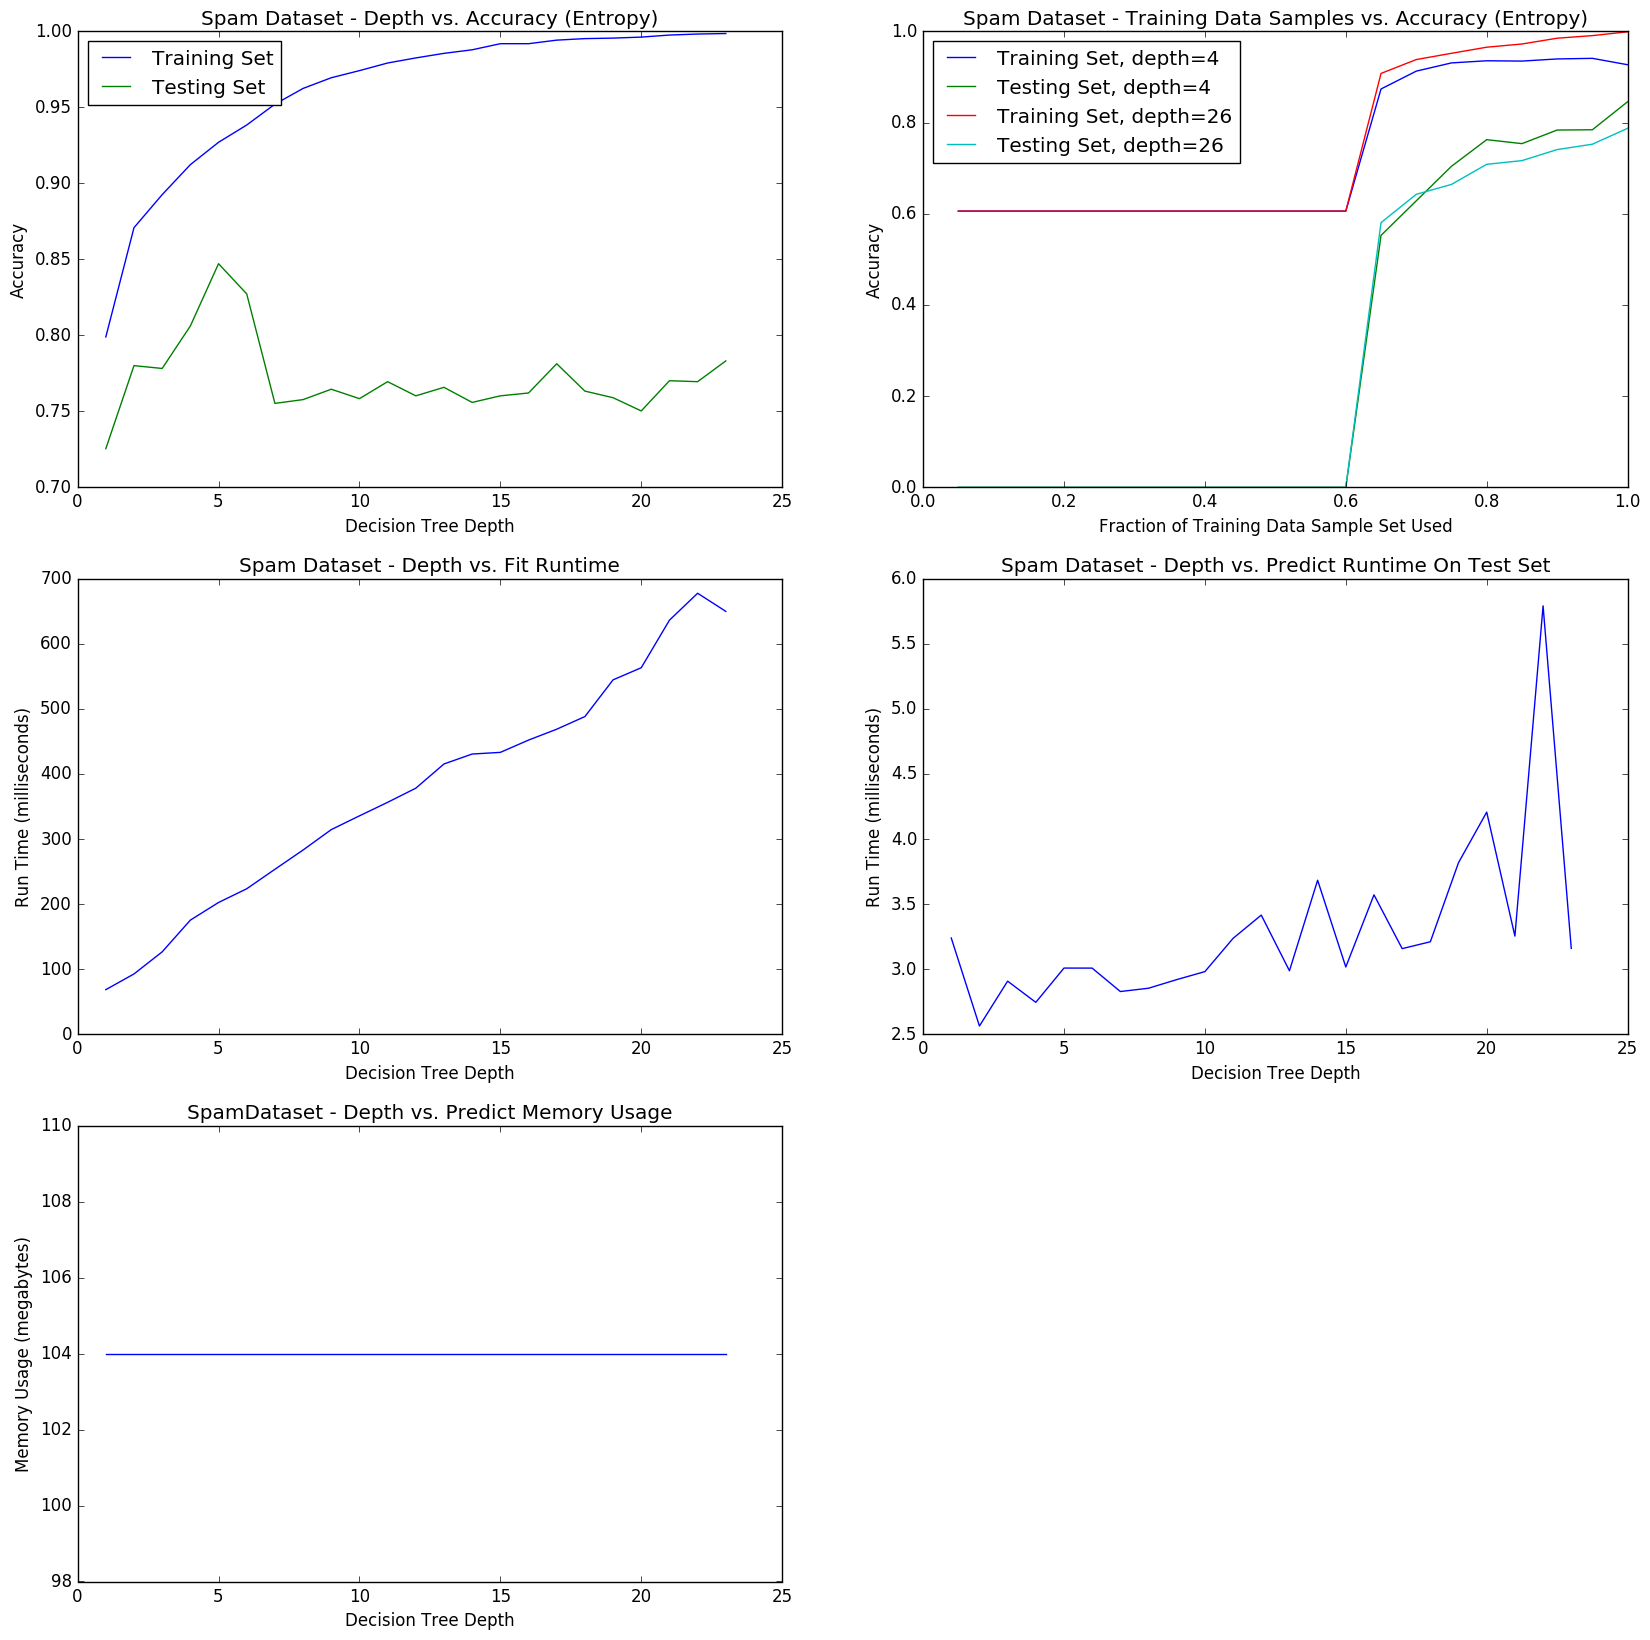

In [23]:
training_accuracy = []
testing_accuracy = []
fit_run_time = []
predict_run_time= []
memory_usage = []

depth_range = range(1,24)

for depth in depth_range:
    clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=depth)
    fit_run_time.append(timeit.timeit("clf.fit(df_training.values[:,0:-2], df_training.values[:,-1])", 
                    "from __main__ import clf, df_training",
                     number = 10))
    
    clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=depth)
    clf.fit(df_training.values[:,0:-2], df_training.values[:,-1])
    memory_usage.append(getsize(clf.tree_))
    
    training_accuracy.append(clf.score(df_training.values[:,0:-2], df_training.values[:,-1]))
    testing_accuracy.append(clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1]))
    
    predict_run_time.append(timeit.timeit("clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1])",
                                          "from __main__ import clf, df_testing",
                                          number=5))
plt.rcParams.update({'font.size': 12})    
fig = plt.figure(figsize=(20,20))    
    
plt.subplot(321)
plt.plot(depth_range, training_accuracy)
plt.plot(depth_range, testing_accuracy)
plt.title(dataset + " Dataset - Depth vs. Accuracy (Entropy)")
plt.xlabel("Decision Tree Depth")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Testing Set"], loc=2)

plt.subplot(323)
plt.title(dataset + " Dataset - Depth vs. Fit Runtime")
plt.plot(depth_range, np.array(fit_run_time) * 1000)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Decision Tree Depth")

plt.subplot(324)
plt.title(dataset + " Dataset - Depth vs. Predict Runtime On Test Set")
plt.plot(depth_range, np.array(predict_run_time) * 1000)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Decision Tree Depth")

plt.subplot(325)
plt.title(dataset + "Dataset - Depth vs. Predict Memory Usage")
plt.plot(depth_range, memory_usage)
plt.ylabel("Memory Usage (megabytes)")
plt.xlabel("Decision Tree Depth")

training_accuracy = []
testing_accuracy = []

percent_of_training_data = np.arange(.05,1.05,.05)
for depth in [5, 24]:
    new_training_accuracy = []
    new_testing_accuracy = []
    for percent in percent_of_training_data:
        clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=depth)
        clf.fit(df_training.values[0:int(percent * len(df_training)),0:-2], \
                df_training.values[0:int(percent * len(df_training)),-1])
    
        new_training_accuracy.append(clf.score(df_training.values[:,0:-2], df_training.values[:,-1]))
        new_testing_accuracy.append(clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1]))
    
    predict_run_time.append(timeit.timeit("clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1])",
                                          "from __main__ import clf, df_testing",
                                          number=5))
    
    training_accuracy.append(new_training_accuracy)
    testing_accuracy.append(new_testing_accuracy)

plt.subplot(322)
#plt.figure()
plt.plot(percent_of_training_data, training_accuracy[0])
plt.plot(percent_of_training_data, testing_accuracy[0])
plt.plot(percent_of_training_data, training_accuracy[1])
plt.plot(percent_of_training_data, testing_accuracy[1])
plt.title("Spam Dataset - Training Data Samples vs. Accuracy (Entropy)")
plt.xlabel("Fraction of Training Data Sample Set Used")
plt.ylabel("Accuracy")
plt.legend(["Training Set, depth=4", "Testing Set, depth=4",
           "Training Set, depth=26", "Testing Set, depth=26"], loc=2)



In [13]:
training_accuracy[0][-1]
testing_accuracy[0][-1]

0.84596273291925461

In [14]:
df_results = pd.DataFrame()
df_results["Algorithm"] = ["Decision Tree Max Depth", "Decision Tree Best Depth"]
df_results["Training Set Accuracy"] = [training_accuracy[1][-1], training_accuracy[0][-1]]
df_results["Testing Set Accuracy"] = [testing_accuracy[1][-1], testing_accuracy[0][-1]]
df_results["Fit Runtime (ms)"] = [fit_run_time[1]*1000, fit_run_time[0]*1000]
df_results["Predict Runtime (ms)"] = [predict_run_time[1]*1000, predict_run_time[0]*1000]
df_results["Memory Usage (bytes)"] = [memory_usage[1], memory_usage[0]]
display(HTML(df_results.to_html(index=False)))

Algorithm,Training Set Accuracy,Testing Set Accuracy,Fit Runtime (ms),Predict Runtime (ms),Memory Usage (bytes)
Decision Tree Max Depth,0.999331,0.771429,107.855882,3.259173,104
Decision Tree Best Depth,0.927090,0.845963,69.882293,3.088512,104


Now let's look at an example with some pruning.

In [15]:
class EvaluateDecisionTree:
    
    def __init__(self, df_training, df_testing, depth_range, criterion):
        self.training_accuracy = []
        self.testing_accuracy = []
        self.fit_run_time = []
        self.predict_run_time= []
        self.memory_usage = []        
        self.depth_range = depth_range
        self.criterion = criterion
        self.df_training = df_training
        self.df_testing = df_testing
        
    def sweep_depth(self):
        for depth in self.depth_range:
            clf = tree.DecisionTreeClassifier(criterion=self.criterion, max_depth = depth)
            self.fit_run_time.append(timeit.timeit("clf.fit(df_training.values[:,0:-2], df_training.values[:,-1])", 
                    "from __main__ import clf, df_training", number = 10))
            clf.fit(self.df_training.values[:,0:-2], self.df_training.values[:,-1])
            self.training_accuracy.append(clf.score(self.df_training.values[:,0:-2], self.df_training.values[:,-1]))
            self.testing_accuracy.append(clf.score(self.df_testing.values[:,0:-2], self.df_testing.values[:,-1]))
            self.memory_usage.append(getsize(clf.tree_))
            
    def sweep_dataset(self):
        self.training_accuracy = []
        self.testing_accuracy = []
        self.fit_run_time = []
        self.predict_run_time= []
        self.memory_usage = [] 
          
        percent_of_training_data = np.arange(.05,1.05,.05)
        self.depth_range = percent_of_training_data
        for percent in percent_of_training_data:
            clf = tree.DecisionTreeClassifier(criterion="entropy")
            clf.fit(self.df_training.values[0:int(percent * len(self.df_training)),0:-2], \
                self.df_training.values[0:int(percent * len(self.df_training)),-1])
    
            self.training_accuracy.append(clf.score(self.df_training.values[:,0:-2], 
                                                    self.df_training.values[:,-1]))
            self.testing_accuracy.append(clf.score(self.df_testing.values[:,0:-2], 
                                                   self.df_testing.values[:,-1]))
            
    def plot_training_accuracy(self):
        plt.plot(self.depth_range, self.training_accuracy)

    def plot_testing_accuracy(self):
        plt.plot(self.depth_range, self.testing_accuracy)

    def plot_fit_run_time(self):
        plt.plot(self.depth_range, self.fit_run_time)

    def plot_predict_run_time(self):
        plt.plot(self.depth_range, self.predict_run_time)

    def plot_memory_usage(self):
        plt.plot(self.depth_range, self.memory_usage)


In [16]:
sweep_range = range(1,25)

no_pruning_entropy = EvaluateDecisionTree(df_training, df_testing, sweep_range, "entropy")
no_pruning_entropy.sweep_depth()
no_pruning_gini    = EvaluateDecisionTree(df_training, df_testing, sweep_range, "gini")
no_pruning_gini.sweep_depth()

df_training_pruned = df_training.drop(df_importance[df_importance["importance"] < .04]["attribute"].values, 1)
df_testing_pruned  = df_testing.drop(df_importance[df_importance["importance"] < .04]["attribute"].values, 1)

pruned_entropy = EvaluateDecisionTree(df_training_pruned, df_testing_pruned, 
                                      sweep_range, "entropy")
pruned_entropy.sweep_depth()

pruned_gini    = EvaluateDecisionTree(df_training_pruned, df_testing_pruned, 
                                      sweep_range, "gini")
pruned_gini.sweep_depth()

fig = plt.figure(figsize=(20,20))  



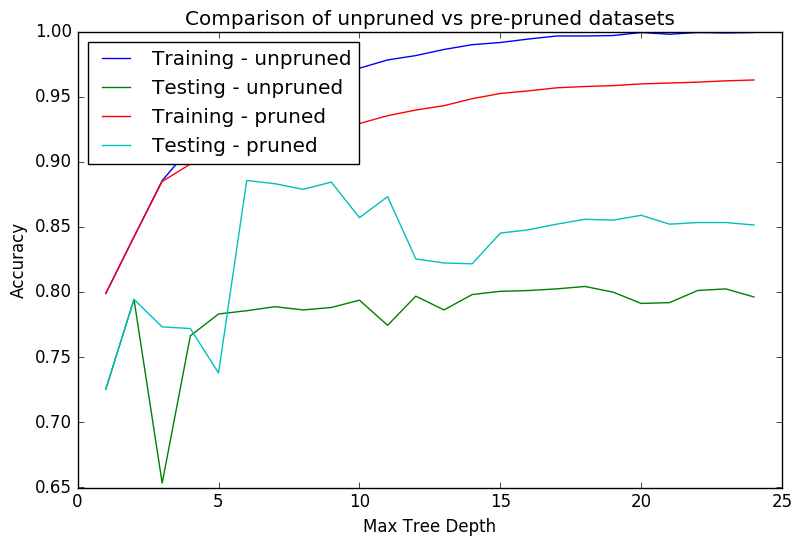

In [17]:
fig = plt.figure(figsize=(20,20))    
plt.subplot(321)

no_pruning_entropy.plot_training_accuracy()
no_pruning_entropy.plot_testing_accuracy()
pruned_entropy.plot_training_accuracy()
pruned_entropy.plot_testing_accuracy()

plt.title("Comparison of unpruned vs pre-pruned datasets")
plt.ylabel("Accuracy")
plt.xlabel("Max Tree Depth")
plt.legend(["Training - unpruned", "Testing - unpruned", "Training - pruned", "Testing - pruned"], loc=2)

In [18]:
sweep_range = range(1,25)

no_pruning_entropy = EvaluateDecisionTree(df_training, df_testing, sweep_range, "entropy")
no_pruning_entropy.sweep_dataset()
no_pruning_gini    = EvaluateDecisionTree(df_training, df_testing, sweep_range, "gini")
no_pruning_gini.sweep_dataset()

df_training_pruned = df_training.drop(df_importance[df_importance["importance"] < .02]["attribute"].values, 1)
df_testing_pruned  = df_testing.drop(df_importance[df_importance["importance"] < .02]["attribute"].values, 1)

pruned_entropy = EvaluateDecisionTree(df_training_pruned, df_testing_pruned, 
                                      sweep_range, "entropy")
pruned_entropy.sweep_dataset()

pruned_gini    = EvaluateDecisionTree(df_training_pruned, df_testing_pruned, 
                                      sweep_range, "gini")
pruned_gini.sweep_dataset()

fig = plt.figure(figsize=(20,20)) 

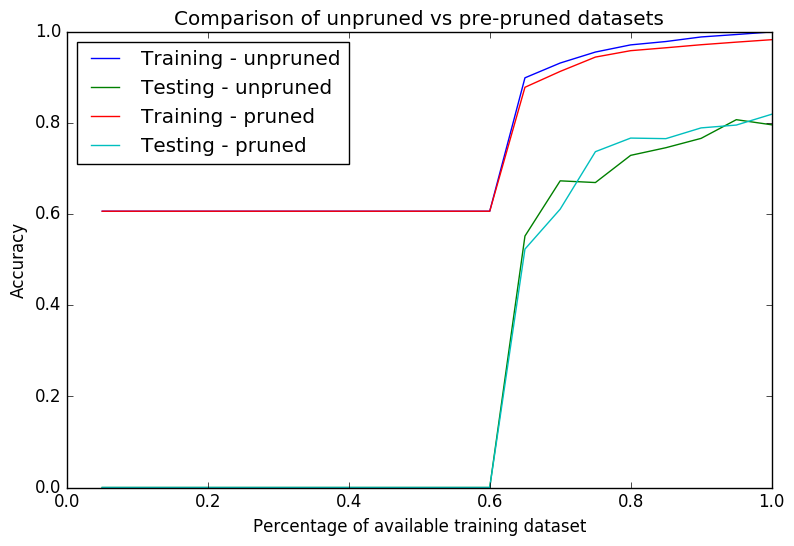

In [19]:
fig = plt.figure(figsize=(20,20))    
plt.subplot(321)

no_pruning_entropy.plot_training_accuracy()
no_pruning_entropy.plot_testing_accuracy()
pruned_entropy.plot_training_accuracy()
pruned_entropy.plot_testing_accuracy()

plt.title("Comparison of unpruned vs pre-pruned datasets")
plt.ylabel("Accuracy")
plt.xlabel("Percentage of available training dataset")
plt.legend(["Training - unpruned", "Testing - unpruned", "Training - pruned", "Testing - pruned"], loc=2)

In [20]:
df_results = pd.DataFrame()
df_results["Algorithm"] = ["Decision Tree Unpruned", "Decision Tree Pruned"]
df_results["Training Set Accuracy"] = [no_pruning_entropy.training_accuracy[-1], pruned_entropy.training_accuracy[-1]]
df_results["Testing Set Accuracy"] = [no_pruning_entropy.testing_accuracy[-1], pruned_entropy.testing_accuracy[-1]]
display(HTML(df_results.to_html(index=False)))

Algorithm,Training Set Accuracy,Testing Set Accuracy
Decision Tree Unpruned,0.999331,0.795652
Decision Tree Pruned,0.982274,0.818634
